# Assignment 2

In [1]:
import matplotlib as plt
import matplotlib.pyplot as pltp
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
import pandas as pd


# Load dataset
file_path = './raw/influenza_weekly.csv'
influenza_data = pd.read_csv(file_path)

#Drop data that isn't from 'Oceania Melanesia Polynesia' flu region
influenza_data = influenza_data[influenza_data['FLUREGION'] == 'Oceania Melanesia Polynesia']

#Transform the date to datetime containing Year/Week/Day
influenza_data['Date'] = pd.to_datetime(influenza_data['Year'].astype(str) + influenza_data['Week'].astype(str).str.zfill(2) + '1', format='%Y%W%w')

#Extract year,month,dayofyear columns from date
influenza_data.loc[:, 'year'] = influenza_data['Date'].dt.year
influenza_data.loc[:, 'month'] = influenza_data['Date'].dt.month
influenza_data.loc[:, 'dayofyear'] = influenza_data['Date'].dt.dayofyear

#Rename ALL_INF to cases
influenza_data['cases'] = influenza_data['ALL_INF']

#Replace the outbreak titles with integers representing each title
influenza_data['title'] = influenza_data['TITLE'].replace({'No Activity': 0, 'Sporadic': 1,
                 'Local Outbreak' : 2, 'Regional Outbreak' : 3, 'Widespread Outbreak' : 4})

#Return a number relating to a season when given a month integer
def get_season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    else:
        return 3

#Create the season column and fill it with data returned from the get_season function  
influenza_data['season'] = influenza_data['month'].apply(lambda x : get_season(x))

#Drop irrelevant columns
influenza_data.drop(['WHOREGION', "ALL_INF2", 'TITLE', 'BNOTDETERMINED', 'BYAMAGATA', 'BVICTORIA', 'INF_B', 'ANOTSUBTYPED','AH5', 'AH3', 'AH1', 'AH1N12009', 'SPEC_RECEIVED_NB', 'SPEC_PROCESSED_NB','INF_A', 'REPORT_ID', 'EDATE', 'SDATE', 'Week', 'Year'], axis=1, inplace=True)

#Print columns
influenza_data.head()

C:\Users\Leoho\AppData\Local\Temp\ipykernel_36088\1448852978.py:15: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  influenza_data = pd.read_csv(file_path)
C:\Users\Leoho\AppData\Local\Temp\ipykernel_36088\1448852978.py:32: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  influenza_data['title'] = influenza_data['TITLE'].replace({'No Activity': 0, 'Sporadic': 1,


,Country,FLUREGION,ALL_INF,Date,year,month,dayofyear,cases,title,season
1375,Australia,Oceania Melanesia Polynesia,0,2005-01-03,2005,1,3,0,0,0
1376,Australia,Oceania Melanesia Polynesia,1,2005-01-03,2005,1,3,1,1,0
1377,Australia,Oceania Melanesia Polynesia,0,2005-01-10,2005,1,10,0,0,0
1378,Australia,Oceania Melanesia Polynesia,0,2005-01-17,2005,1,17,0,0,0
1379,Australia,Oceania Melanesia Polynesia,0,2005-01-24,2005,1,24,0,0,0


**Plotting Data**

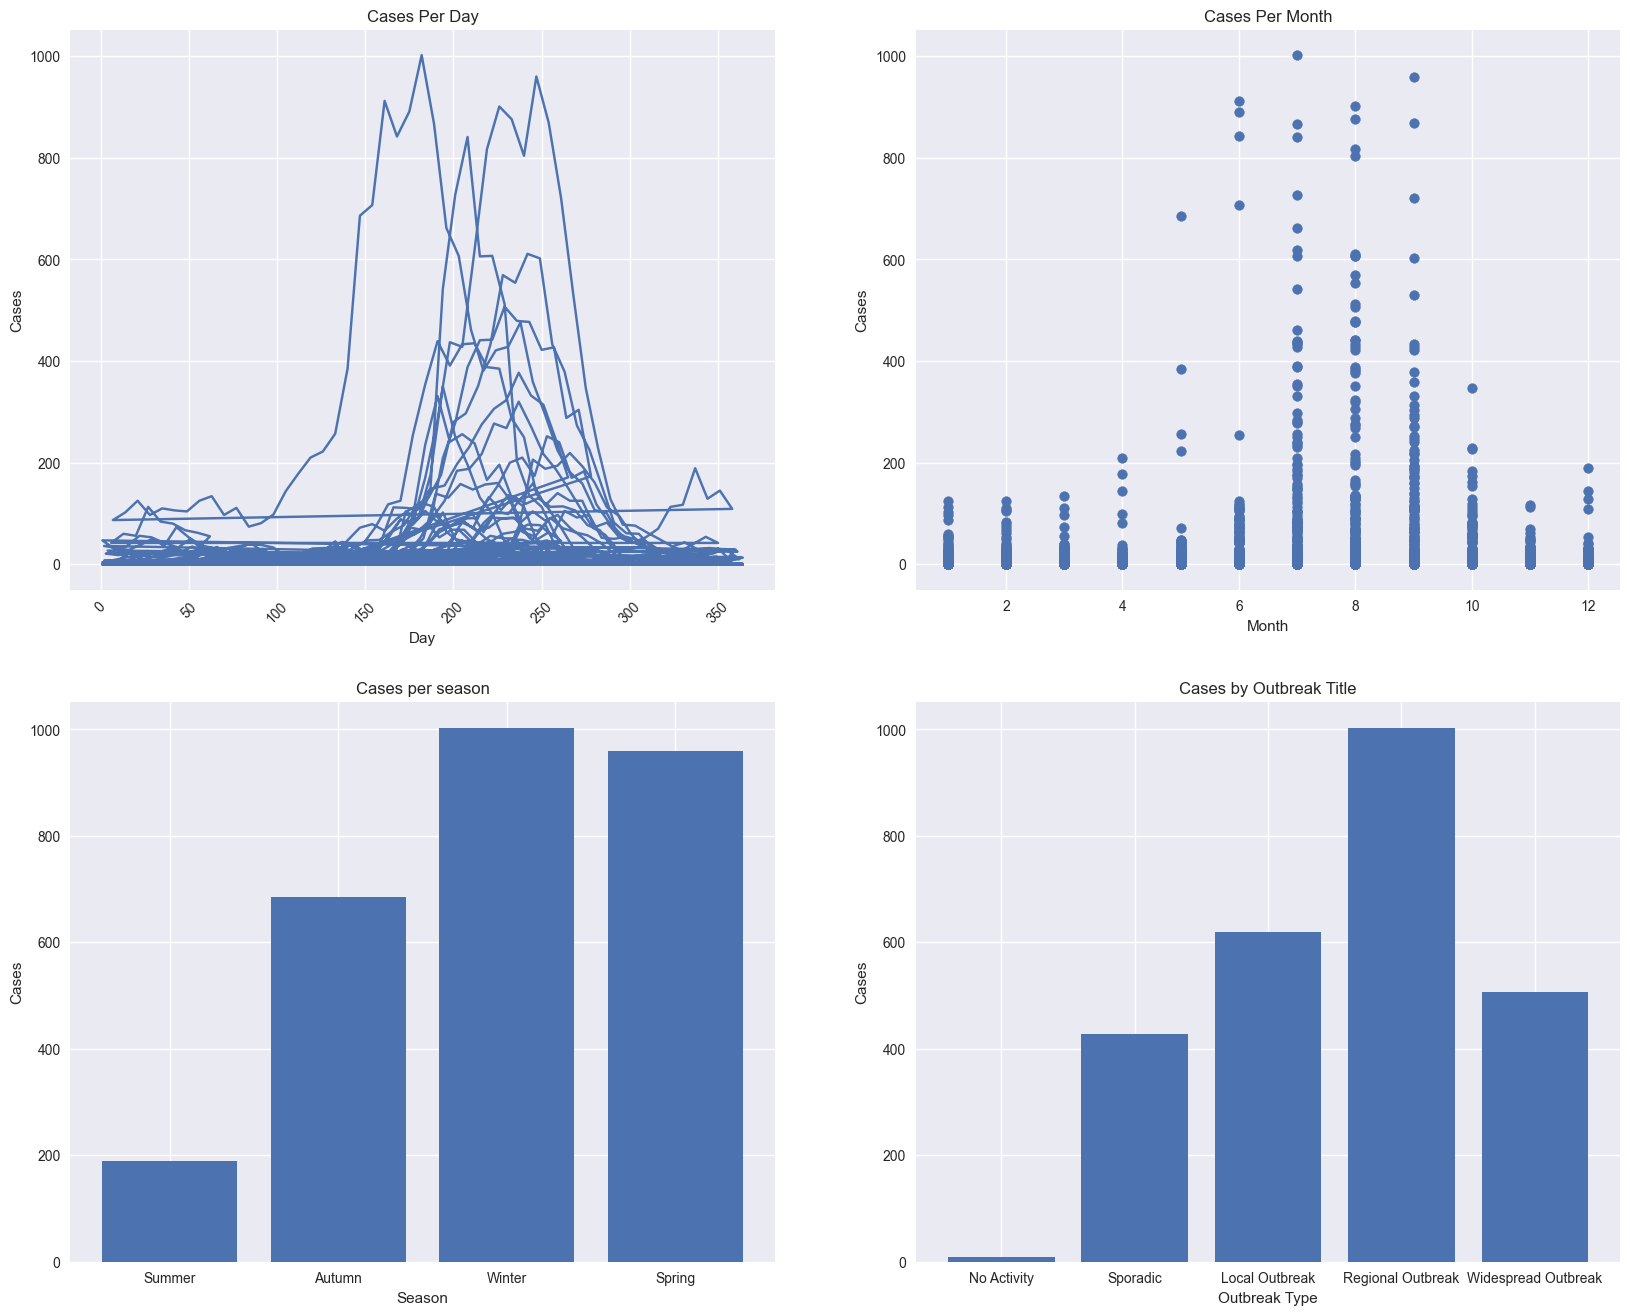

In [4]:
import matplotlib
matplotlib.pyplot.style.use('seaborn-v0_8')

#Create subplots
fig, axes = matplotlib.pyplot.subplots(2, 2, figsize=(20, 16))

#Plot the cases per day of year
axes[0, 0].plot(influenza_data['dayofyear'], influenza_data['cases'])
axes[0, 0].set_title('Cases Per Day')
axes[0, 0].set_xlabel('Day')
axes[0, 0].set_ylabel('Cases')
axes[0, 0].tick_params(axis='x', rotation=45)

#Plot the cases per month
axes[0, 1].scatter(influenza_data['month'], influenza_data['cases'])
axes[0, 1].set_title('Cases Per Month')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Cases')

#Plot the cases per season
axes[1, 0].bar(influenza_data['season'], influenza_data['cases'])
axes[1, 0].set_title('Cases per season')
axes[1, 0].set_ylabel('Cases')
axes[1, 0].set_xlabel('Season')
axes[1, 0].set_xticks(ticks=[0, 1, 2, 3], labels=['Summer', 'Autumn', 'Winter', 'Spring'])

#Plot the cases by outbreak title
axes[1, 1].bar( influenza_data['title'], influenza_data['cases'])
axes[1, 1].set_title('Cases by Outbreak Title')
axes[1, 1].set_ylabel('Cases')
axes[1, 1].set_xlabel('Outbreak Type')
axes[1, 1].set_xticks(ticks=[0, 1, 2, 3, 4], labels=['No Activity', 'Sporadic', 'Local Outbreak', 'Regional Outbreak', 'Widespread Outbreak'])


**Gradient Booster Regression**

Random Forest root Mean squared error: 80.47947870568852
Random Forest R-squared score: 0.5130758916231744
month: 0.12372465754542915
year: 0.3069180352512265
season: 0.03402860675198517
title: 0.5353287004513592


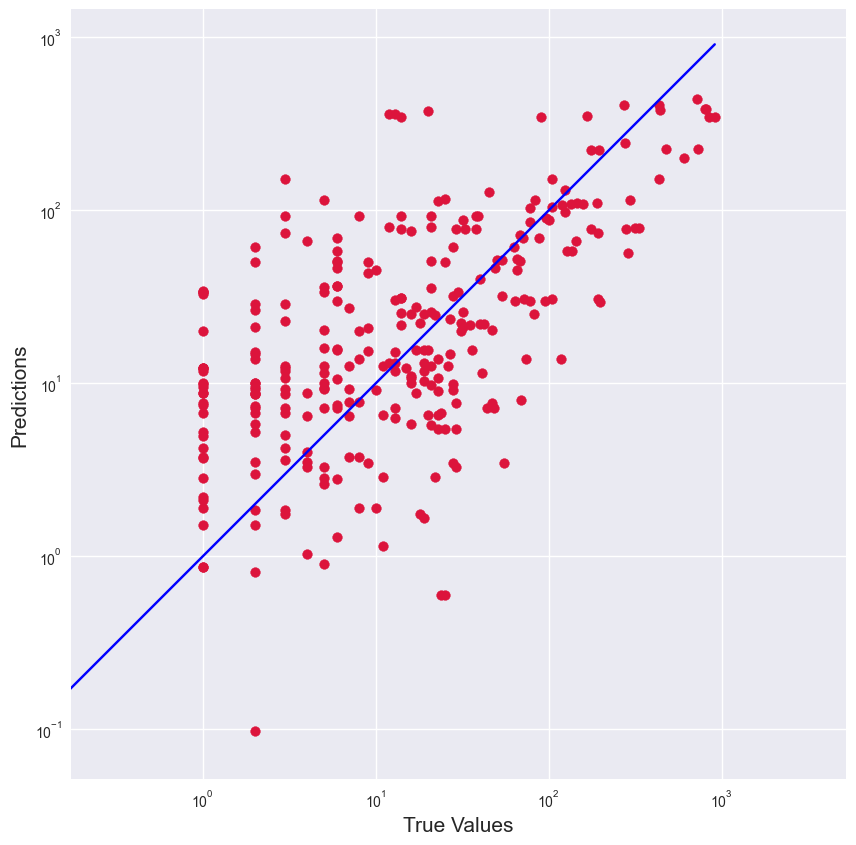

In [8]:
from sklearn.metrics import root_mean_squared_error, r2_score

#Select features and target
features = [ 'month', 'year', 'season', 'title']
GBX = influenza_data[features]
GBy = influenza_data['cases']

#Split the data
GBX_train, GBX_test, GBy_train, GBy_test = train_test_split(GBX, GBy, test_size=0.2, random_state=42)

#Create and train the model using training data
model = GradientBoostingRegressor(n_estimators=1000, random_state=42)
model.fit(GBX_train, GBy_train)

#Make predictions using test data
GBy_pred = model.predict(GBX_test)

#Evaluate the model using RMSE and R2 scores
GBrmse = root_mean_squared_error(GBy_test, GBy_pred)
GBr2 = r2_score(GBy_test, GBy_pred)

print(f"Random Forest root Mean squared error: {GBrmse}")
print(f"Random Forest R-squared score: {GBr2}")

#Display the features and their importance
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")

#Plot the predicted and true values from the model
pltp.figure(figsize=(10,10))
pltp.scatter(GBy_test, GBy_pred, c='crimson')
pltp.yscale('log')
pltp.xscale('log')

p1 = max(max(GBy_pred), max(GBy_test))
p2 = min(min(GBy_pred), min(GBy_test))
pltp.plot([p1, p2], [p1, p2], 'b-')
pltp.xlabel('True Values', fontsize=15)
pltp.ylabel('Predictions', fontsize=15)
pltp.axis('equal')
pltp.show()


**Random Forest Regression**

Random Forest root Mean squared error: 79.2827350446499
Random Forest R-squared score: 0.5274495121129873
month: 0.17374713301930134
year: 0.363183572239892
season: 0.04112648107610143
title: 0.42194281366470526


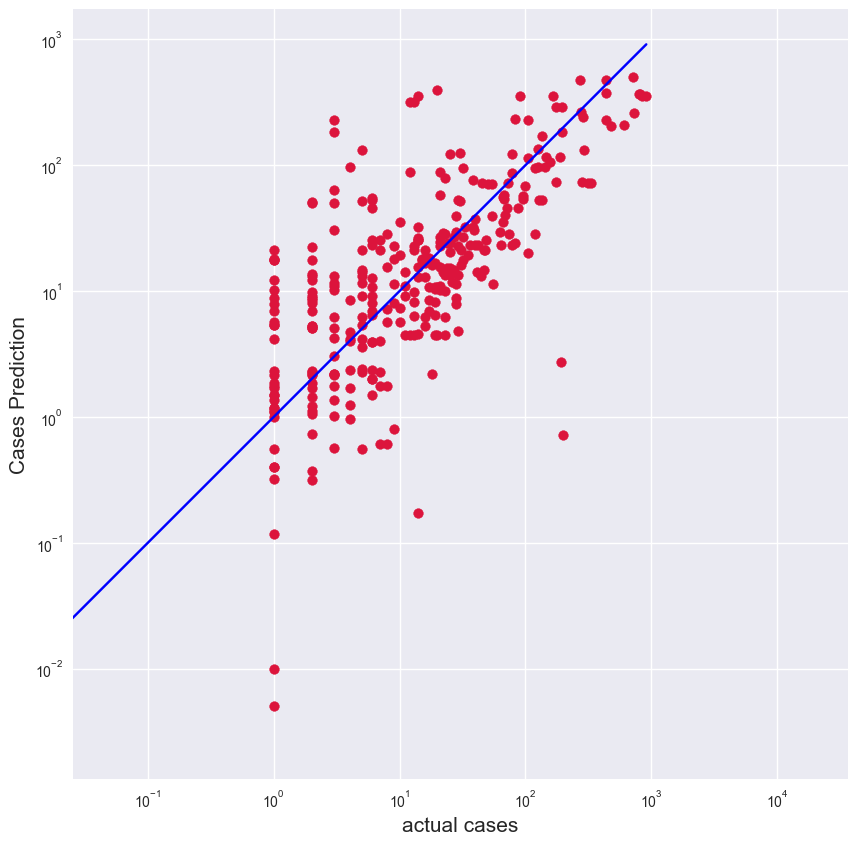

In [11]:

#Select features and target
features = [ 'month', 'year', 'season', 'title']
RFX = influenza_data[features]
RFy = influenza_data['cases']

#Split the data
RFX_train, RFX_test, RFy_train, RFy_test = train_test_split(RFX, RFy, test_size=0.2, random_state=42)

#Create and train the model using the training data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(RFX_train, RFy_train)

#Make predictions using the testing data
y_pred = model.predict(RFX_test)

# Evaluate the model using RMSE and R2 scores
RFrmse = root_mean_squared_error(RFy_test, y_pred)
RFr2 = r2_score(RFy_test, y_pred)

print(f"Random Forest root Mean squared error: {RFrmse}")
print(f"Random Forest R-squared score: {RFr2}")

#Display the features and their importance
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")

#Plot the predicted and true values from the model
pltp.figure(figsize=(10,10))
pltp.scatter(RFy_test, y_pred, c='crimson')
pltp.yscale('log')
pltp.xscale('log')

p1 = max(max(y_pred), max(RFy_test))
p2 = min(min(y_pred), min(RFy_test))
pltp.plot([p1, p2], [p1, p2], 'b-')
pltp.xlabel('actual cases', fontsize=15)
pltp.ylabel('Cases Prediction', fontsize=15)
pltp.axis('equal')
pltp.show()

**Random Forest Classifier**

Accuracy: 0.27634660421545665
Precision: 0.20455175951417162
Recall: 0.27634660421545665
F1-Score: 0.22853221904467394
month: 0.19895485069774851
year: 0.49604110828072523
season: 0.046576160583247046
title: 0.25842788043827913


c:\Users\Leoho\GitHub\Assign3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Leoho\GitHub\Assign3\venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Text(0.5, 1.0, 'Predictions vs True Values')

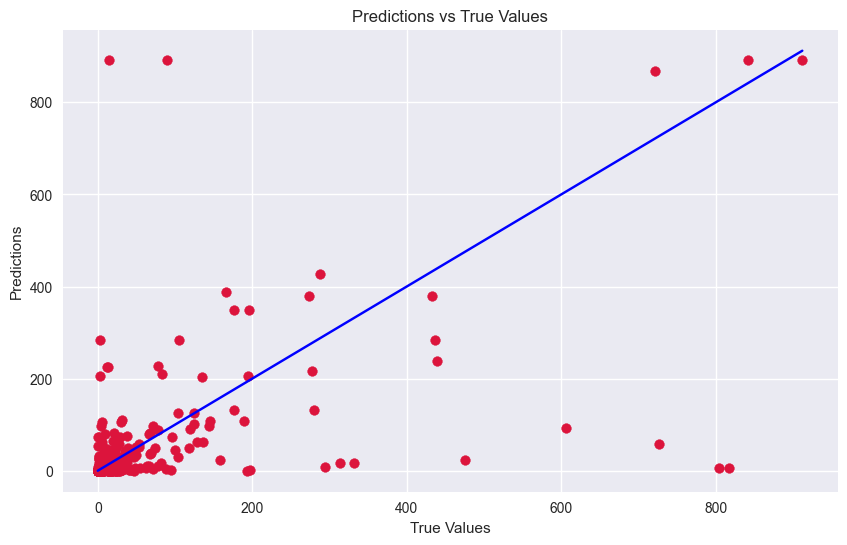

In [12]:
#Select features and target
features = ['month', 'year', 'season', 'title']
RFX = influenza_data[features]
RFy = influenza_data['cases']

#Split the data
RFX_train, RFX_test, RFy_train, RFy_test = train_test_split(RFX, RFy, test_size=0.2, random_state=42)

#Create and train the model using training data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(RFX_train, RFy_train)

#Make predictions using testing data
y_pred = model.predict(RFX_test)

#Evaluate the model using accuracy, precision, recall and f1 scores
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(RFy_test, y_pred)
precision = precision_score(RFy_test, y_pred, average='weighted')  
recall = recall_score(RFy_test, y_pred, average='weighted')
f1 = f1_score(RFy_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

#Display the features and their importance
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")

#Plot the predicted and true values of the model
pltp.figure(figsize=(10,6))
pltp.scatter(RFy_test, y_pred, c='crimson')
pltp.plot([min(RFy_test), max(RFy_test)], [min(RFy_test), max(RFy_test)], 'b-')

pltp.xlabel('True Values')
pltp.ylabel('Predictions')
pltp.title('Predictions vs True Values')

**XGBoost Regression**

XGBoost root Mean squared error: 79.70181274414062
XGBoost R-squared score: 0.5224405527114868
month: 0.10893664509057999
year: 0.1996350884437561
season: 0.1887267678976059
title: 0.5027015209197998


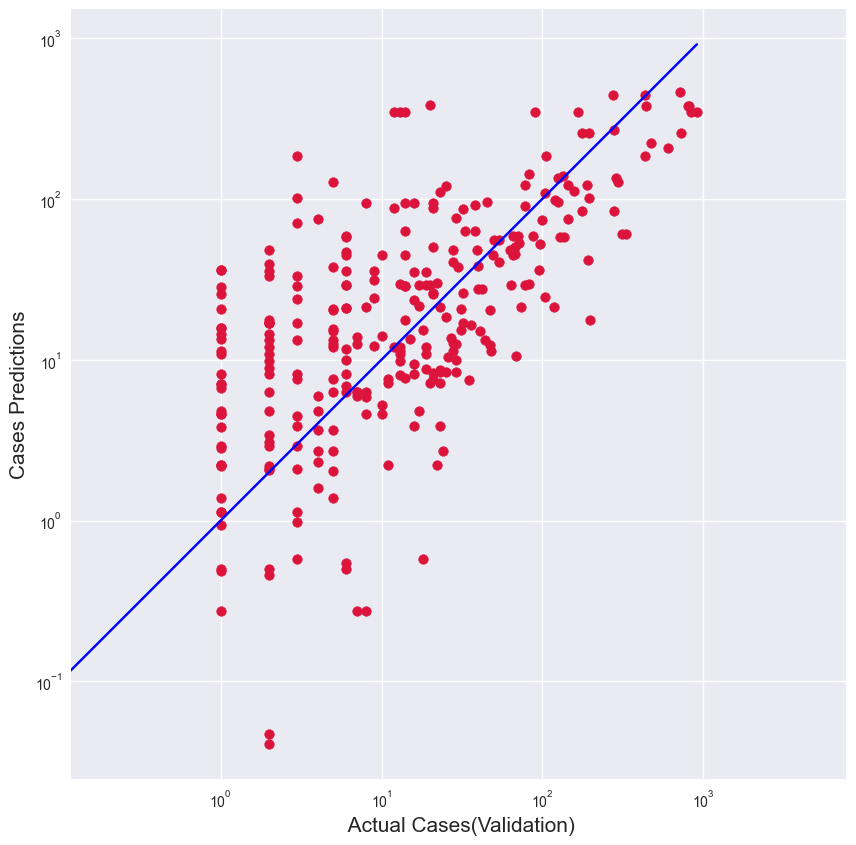

In [15]:
#Select features and target
features = ['month', 'year', 'season', 'title']
GBRX = influenza_data[features]
GBRy = influenza_data['cases']

# plit the data
GBRX_train, GBRX_test, GBRy_train, GBRy_test = train_test_split(GBRX, GBRy, test_size=0.2, random_state=42)

#Create and train the model using training data and specifying the learning objective
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth=3, random_state=42)
model.fit(GBRX_train, GBRy_train)

#Make predictions using testing data
GBRy_pred = model.predict(GBRX_test)

#Evaluate the model using RMSE and R2 scores
GBRmse = root_mean_squared_error(GBRy_test, GBRy_pred)
GBRr2 = r2_score(GBRy_test, GBRy_pred)

print(f"XGBoost root Mean squared error: {GBRmse}")
print(f"XGBoost R-squared score: {GBRr2}")

#Display the features and their importance
for feature, importance in zip(features, model.feature_importances_):
    print(f"{feature}: {importance}")

#Plot the predicted and true values on the model
pltp.figure(figsize=(10,10))
pltp.scatter(GBRy_test, GBRy_pred, c='crimson')
pltp.yscale('log')
pltp.xscale('log')

p1 = max(max(GBRy_pred), max(GBRy_test))
p2 = min(min(GBRy_pred), min(GBRy_test))
pltp.plot([p1, p2], [p1, p2], 'b-')
pltp.xlabel(' Actual Cases(Validation)', fontsize=15)
pltp.ylabel('Cases Predictions', fontsize=15)
pltp.axis('equal')
pltp.show()